# New Covid Cases Prediction By Time Series Forecasting Using LSTM Models

In [30]:
import pandas as pd
import numpy as np
import sweetviz as sv

In [3]:
df = pd.read_csv("covid_19_india.csv")
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [4]:
df = df.drop(['Sno', 'Time'], axis = 1)
df.head()

,Date,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,2020-01-30,Kerala,1,0,0,0,1
1,2020-01-31,Kerala,1,0,0,0,1
2,2020-02-01,Kerala,2,0,0,0,2
3,2020-02-02,Kerala,3,0,0,0,3
4,2020-02-03,Kerala,3,0,0,0,3


In [5]:
df.tail()

,Date,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
16845,2021-07-07,Telangana,-,-,613124,3703,628282
16846,2021-07-07,Tripura,-,-,63964,701,68612
16847,2021-07-07,Uttarakhand,-,-,332006,7338,340882
16848,2021-07-07,Uttar Pradesh,-,-,1682130,22656,1706818
16849,2021-07-07,West Bengal,-,-,1472132,17834,1507241


# Grouping by Date

**In order to get the covid cases related to the whole country rather than a state we need to group by sum all entries
with respect to the date**

In [6]:
# Creating a grouped Dataset
groupedDF = df.groupby(['Date']).sum()
groupedDF.reset_index(drop=True, inplace=True)
groupedDF.head()

,Cured,Deaths,Confirmed
0,0,0,1
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,3


# Constructing active cases from the available data

**When we subtract Deaths and Cured cases from the Confirmed cases of that day we will land on the Active cases on that day**

In [7]:
# Constructing active case count from the available data
groupedDF['active'] = groupedDF.apply(lambda x: (x['Confirmed'] - x['Deaths'] - x['Cured']), axis=1)
groupedDF.head()

,Cured,Deaths,Confirmed,active
0,0,0,1,1
1,0,0,1,1
2,0,0,2,2
3,0,0,3,3
4,0,0,3,3


# Constructing New cases

**When we subtract the confirmed cases of today from the previous day we will end up getting new cases of everyday.**

In [8]:
# constructing new cases count from available data
prev_value = 0
def getNewCases(row):
    global prev_value
    new_value =  row["Confirmed"] - prev_value
    prev_value = row['Confirmed']
    return new_value


groupedDF['new'] = groupedDF.apply(getNewCases, axis=1)
groupedDF.head()

,Cured,Deaths,Confirmed,active,new
0,0,0,1,1,1
1,0,0,1,1,0
2,0,0,2,2,1
3,0,0,3,3,1
4,0,0,3,3,0


In [9]:
groupedDF.tail()

,Cured,Deaths,Confirmed,active,new
520,29605779,401050,30502362,495533,44111
521,29658078,402005,30545433,485350,43071
522,29700430,402728,30585229,482071,39796
523,29752294,403281,30619932,464357,34703
524,29799534,404211,30663665,459920,43733


<AxesSubplot:ylabel='active'>

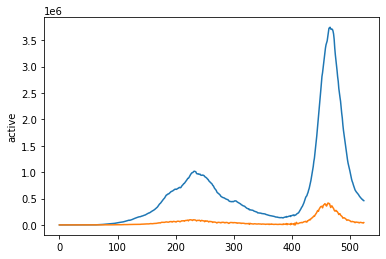

In [10]:
import seaborn as sns
sns.lineplot(data=groupedDF['active'])
sns.lineplot(data=groupedDF['new'])

In [11]:
groupedDF.describe()

,Cured,Deaths,Confirmed,active,new
count,5.250000e+02,525.000000,5.250000e+02,5.250000e+02,525.000000
mean,7.575608e+06,111859.047619,8.292339e+06,6.048723e+05,58406.980952
std,8.207117e+06,107110.277417,8.794737e+06,8.206081e+05,85760.289764
min,0.000000e+00,0.000000,1.000000e+00,1.000000e+00,0.000000
25%,1.292150e+05,7466.000000,2.665980e+05,1.299170e+05,8909.000000
50%,6.597209e+06,114031.000000,7.494551e+06,3.223660e+05,30006.000000
75%,1.075068e+07,156825.000000,1.106349e+07,7.292430e+05,64553.000000
max,2.979953e+07,404211.000000,3.066366e+07,3.745237e+06,414188.000000


**New cases range between 0 to 414188. So, it's a good idea to scale the data. Z scaling works great here**

In [12]:
# Let's focus only on scaled new case estimations.
from sklearn import preprocessing
scalar = preprocessing.StandardScaler()
newcases = scalar.fit_transform(np.array(groupedDF['new']).reshape(-1,1))
newcases[:10]

C:\Users\bhanu\anaconda3\envs\tf_gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


array([[-0.68168712],
       [-0.6816988 ],
       [-0.68168712],
       [-0.68168712],
       [-0.6816988 ],
       [-0.6816988 ],
       [-0.6816988 ],
       [-0.6816988 ],
       [-0.6816988 ],
       [-0.6816988 ]])

In [13]:
# Creating a test and train split w/o shufle because we need order. 425 are used for train and 100 for test
trainSplit = newcases[:425]
testSplit = newcases[425:]
print(trainSplit.shape, testSplit.shape)

(425, 1) (100, 1)


# Constructing LSTM acceptable data

**LSTM needs a 3D dataset, where 1st Dim is the no.of days considered in each iteration here it's 30, No of records, and 3rd dimension is just a place holder here because our data is 2D.**

In [14]:
# Constructing a 30 day timeseries data frame
def createTimeSeriesData(timeSteps, data):
    processedXSet = []
    processedySet = []
    data = data.reshape(-1)
    pointer = 0
    for i in range(timeSteps, len(data)):
        processedXSet.append(data[pointer:timeSteps+pointer])
        processedySet.append(data[timeSteps+pointer])
        pointer+=1
    return [np.array(processedXSet), np.array(processedySet)]

In [15]:
X_train, y_train = createTimeSeriesData(30, trainSplit)
X_test, y_test = createTimeSeriesData(30, testSplit)

In [16]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
# Model Building stage
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Building a STACKED LSTM Model


In [18]:
model = Sequential()
model.add(LSTM(300, return_sequences=True,input_shape=(30,1)))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
7/7 [==============================] - 22s 163ms/step - loss: 0.1163 - val_loss: 1.4689
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0255 - val_loss: 0.6163
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0124 - val_loss: 0.5128
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0112 - val_loss: 0.3540
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0093 - val_loss: 0.2847
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.3029
Epoch 7/200
7/7 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.5719
Epoch 8/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0043 - val_loss: 0.8221
Epoch 9/200
7/7 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 1.3519
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0044 - val_loss: 1.9237
Epoch 11/200
7/7 

7/7 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.4200
Epoch 84/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0036 - val_loss: 0.5006
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0028 - val_loss: 0.5511
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.4877
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0030 - val_loss: 0.5254
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.7296
Epoch 89/200
7/7 [==============================] - 0s 19ms/step - loss: 0.0038 - val_loss: 0.7439
Epoch 90/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.6702
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0033 - val_loss: 0.6271
Epoch 92/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 0.4937
Epoch 93/200
7/7 [=====

7/7 [==============================] - 0s 22ms/step - loss: 0.0033 - val_loss: 0.5710
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.7241
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.5767
Epoch 168/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0032 - val_loss: 0.5357
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0030 - val_loss: 0.5288
Epoch 170/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.4518
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0032 - val_loss: 0.4575
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0029 - val_loss: 0.5249
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0028 - val_loss: 0.5587
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.6270
Epoch 175/200


# Saving the trained LSTM model using KERAS save function

In [20]:
# Save and load model
model.save('covidlstm')
from tensorflow import keras
model = keras.models.load_model('covidlstm')

INFO:tensorflow:Assets written to: covidlstm\assets


INFO:tensorflow:Assets written to: covidlstm\assets


In [21]:
#Accuracy measures
import tensorflow as tf

In [22]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [23]:
##Transformback to original form
train_predict=scalar.inverse_transform(train_predict)
test_predict=scalar.inverse_transform(test_predict)

In [24]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

C:\Users\bhanu\anaconda3\envs\tf_gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


40029.46840907773

In [25]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

150926.74012318996

# Creating Future

In order to plot the future we need to predict each day and update the next series and predict again and continue

In [26]:
# Predicting the unknown
def constructFuture(firstSet, days):
    results = np.array([[]])
    for i in range(days):
        prediction = model.predict(firstSet)
        results = np.append(results, prediction)
        s1 = np.delete(firstSet[0], 0, 0)
        s2 = np.append(s1, prediction)
        firstSet = s2.reshape(1, 30, 1)
    return results.reshape(days, 1)

In [27]:
futurestart = np.array([newcases[495:, :]])

future_predict = constructFuture(futurestart, 30)
print(future_predict.shape)

(30, 1)


# Plotting the graph

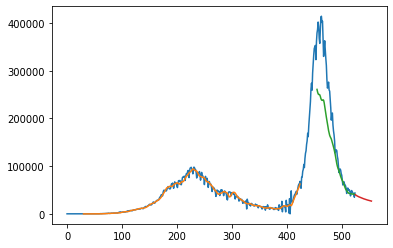

In [28]:
import matplotlib.pyplot as plt
plt.plot(scalar.inverse_transform(newcases))
plt.plot(np.concatenate((np.full([30,1], np.nan), train_predict)))
plt.plot(np.concatenate((np.full([455,1], np.nan), test_predict)))

plt.plot(np.concatenate((np.full([525,1], np.nan), scalar.inverse_transform(future_predict))))

# Pickling to Support Flask API

In [29]:
# pickiling
import pickle
activecases = groupedDF['active'].tolist()
newcasesInv = scalar.inverse_transform(newcases).flatten().tolist()
training = np.concatenate((np.full([30,1], np.nan), train_predict)).flatten().tolist()
training = [None if np.isnan(x)== True else x for x in training]
testing = np.concatenate((np.full([455,1], np.nan), test_predict)).flatten().tolist()
testing = [None if np.isnan(x)== True else x for x in testing]
future = np.concatenate((np.full([525,1], np.nan), scalar.inverse_transform(future_predict))).flatten().tolist()
future = [None if np.isnan(x)== True else x for x in future]
pickle_data = {"activecases":activecases, "newcases":newcasesInv, "training": training, "testing": testing, "future":future}
file_name = "covidreport.pkl"

open_file = open(file_name, "wb")
pickle.dump(pickle_data, open_file)
open_file.close()